
# Parallelization pattern

Language models are powerful, but many tasks require more than a single response from a single prompt. In many AI workflows, especially content generation or creative tasks, it can be more effective to run multiple prompts in parallel and then combine their results. This is known as the parallelization pattern.

Rather than chaining prompts sequentially - where one step waits on the result of the previous - we launch independent LLM calls at the same time. Each parallel step performs its task using the same input (e.g., a topic), and their outputs are then merged into a final result.

In this notebook, we will implement a parallel prompt workflow using a simple topic as input, with three outputs created in parallel and aggregated into one result.

In [1]:
import os
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure OpenAI API key for AI model access
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Initialize the language model
The language model serves as the core intelligence of our conversational agent. Here we will configure the AI model with specific parameters that balance response quality, cost and performance.

In [2]:
# Initialize the OpenAI LLM
llm = ChatOpenAI(
    model="gpt-4o-mini-2024-07-18",
    temperature=0.7  # balanced creativity
)

This configuration creates our AI model instance using OpenAI's GPT model.

In [3]:
# Helper to extract plain text from LLM responses
def to_text(msg):
    return msg.content if hasattr(msg, "content") else str(msg)

### Defining the graph state
Before we define the graph itself, we need to be explicit about the structure of the data that flows through it. LangGraph uses a shared mutable state that each node can read from and write to. This state needs to be clearly defined upfront so that nodes know what fields to expect and what they are allowed to modify.

In our case, all nodes work off the same input topic, but each one is responsible for generating a different type of content: a joke, a story, or a poem. These outputs will then be combined later in the pipeline.

To capture this, we define a Python `TypedDict` that serves as the schema for the state. It's a clean, type-safe way to specify the fields that make up the shared memory of the workflow.



In [4]:
# Define the workflow state
class State(TypedDict):
    topic: str  # User-provided topic
    joke: str  # Output from joke generator
    story: str  # Output from story generator
    poem: str  # Output from poem generator
    combined_output: str  # Final combined output

This `State` acts like a schema for the data flowing through the LangGraph.

Each generation node will:
- Read from the `topic` field
- Write its specific output field (`joke`, `story`, or `poem`)

These operations are entirely independent, which is what makes them suitable for parallel execution.

The final `aggregator` will combine all outputs into `combined_output`.

### Creating prompt nodes
Now we define each LLM node in the graph. These are the actual calls to the OpenAI model. Each function receives the shared `state`, uses the topic, and returns a dictionary with one new key (e.g., joke, story, poem).

#### Node 1: Generate a joke

In [5]:
def call_llm_1(state: State):
    """Generates a joke about the given topic."""
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": to_text(msg)}

#### Node 2: Generate a story

In [6]:
def call_llm_2(state: State):
    """Generate a short story about the topic."""
    msg = llm.invoke(f"Write a short story about {state['topic']}.")
    return {"story": to_text(msg)}

#### Node 3: Generate a poem

In [7]:
def call_llm_3(state: State):
    """Generate a poem about the topic."""
    msg = llm.invoke(f"Write a short poem about {state['topic']}.")
    return {"poem": to_text(msg)}

Each of these nodes:
- Takes in the current state (including the topic),
- Sends a prompt to the model,
- Returns a new field to update the state with its generated result.

These can run in parallel since they are independent of each other.

### Node 4: Aggregator node
Once all generation is complete, we need a node to merge the outputs into a readable format. This node expects all 3 fields (`joke`, `story`, `poem`) to be available in the state.


In [8]:
def aggregator(state: State):
    """Combine joke, story, and poem into a single output string."""
    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"📝 STORY:\n{state['story']}\n\n"
    combined += f"😂 JOKE:\n{state['joke']}\n\n"
    combined += f"🎵 POEM:\n{state['poem']}"
    return {"combined_output": combined}

This node is purely formatting — it does no generation. It assumes all previous steps have been completed and the relevant fields are populated. It outputs a new field `combined_output` that we will use to present the final result to the user.

### Building the workflow graph
Now that we have defined the nodes and the structure of the state, it is time to assemble everything into an executable workflow. LangGraph lets us define workflows as graphs - a flexible way of modeling prompt logic where nodes represent LLM calls (or other logic), and edges represent control flow between them.

In this case, we want a parallel fan-out → fan-in pattern:
- The graph begins at a `START` node.
- From there, we branch into three independent generation tasks: joke, story, and poem.
- Once all three are complete, their outputs are passed into a single `aggregator` node.
- The workflow ends after the aggregator has run.

Importantly, the aggregator will only execute once all three parent nodes have completed. LangGraph automatically manages this synchronization.

In [9]:
# Build workflow graph
builder = StateGraph(State)

# Register nodes
builder.add_node("call_llm_1", call_llm_1)
builder.add_node("call_llm_2", call_llm_2)
builder.add_node("call_llm_3", call_llm_3)
builder.add_node("aggregator", aggregator)

# Wire edges: all three tasks start from START
builder.add_edge(START, "call_llm_1")
builder.add_edge(START, "call_llm_2")
builder.add_edge(START, "call_llm_3")

# Merge into aggregator
builder.add_edge("call_llm_1", "aggregator")
builder.add_edge("call_llm_2", "aggregator")
builder.add_edge("call_llm_3", "aggregator")

# Aggregator leads to END
builder.add_edge("aggregator", END)

# Compile the workflow to a runnable chain
workflow = builder.compile()

- We start by initializing the `StateGraph` with our previously defined `State` schema.
- Each of the three LLM call functions is added as a node. These nodes are independent and can run concurrently.
- All three nodes are wired to begin execution directly from `START`. This is what enables parallel execution - they don't depend on each other.
- Once each of the generation tasks finishes, the output is passed to the `aggregator`. LangGraph handles synchronization here - the `aggregator` will wait until all three upstream nodes have completed and updated the state.
- After aggregation is complete, we connect it to the `END` node, marking the conclusion of the workflow.
- Finally, we compile the graph into a runnable chain. This gives us a clean abstraction to invoke the full process using just an input state.

#### Visualizing the Workflow
Let’s display the graph visually to better understand the chain.

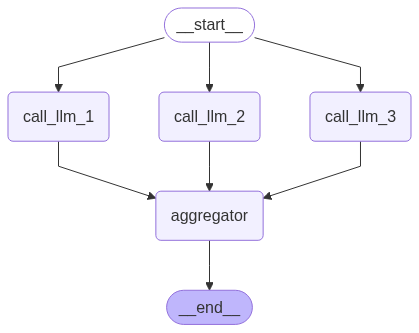

In [10]:
# Visualize the graph
display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Running the workflow
Let’s invoke the chain with a sample input topic and see how it will generate a joke, a story, and a poem in parallel, and then combine them.


In [11]:
# Run the parallel workflow with a sample topic
state = workflow.invoke({"topic": "cats"})

# Print the final result
print(state["combined_output"])

Here's a story, joke, and poem about cats!

📝 STORY:
In a quaint little town nestled between rolling hills, there was a cozy bookstore called "Whiskers & Words." The store was known not just for its vast collection of books but also for its charming feline residents: a trio of cats named Oliver, Luna, and Jasper. Each cat had a distinct personality that matched their unique appearances.

Oliver was a portly tabby with a penchant for napping in the sunniest spots of the store. He would often be found sprawled atop a pile of hardcover novels, his purring vibrating softly through the shelves. Luna, a sleek black cat with mesmerizing green eyes, was the store’s guardian, always alert and watching over the customers with a mysterious air. Jasper, the youngest of the three, was a fluffy ginger ball of energy, constantly darting around, chasing dust motes and pouncing on unsuspecting customers’ shoelaces.

One rainy afternoon, as the pitter-patter of raindrops danced on the roof, the bookstor

We now have a single output that merges the three parallel generations.